In [2]:
# 모듈로딩
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [3]:
mnist = fetch_openml('mnist_784', as_frame = False)

c:\ProgramData\anaconda3\envs\Torch_PY38\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
featureNP, targetNP = mnist.data / 255.0, mnist.target

In [5]:
# 데이터의 Tensor 변환
class DLDataset(Dataset):

    # 초기화 콜백 함수(callback function)
    def __init__(self, x_data, y_data):
        super().__init__()
        # x, y 데이터 => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data

        # ndarray => tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.FloatTensor(y_data)  # 타겟을 원핫인코딩하면 FloatTensor 사용
        print('[target & target shape]', self.target.shape, self.target.ndim)
    
    # 데이터셋의 개수 체크 콜백 함수(callback function)
    def __len__(self):
        return self.target.shape[0]
    
    # 특정 인덱스 데이터 + 라벨 반환 콜백 함수(callback function)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [6]:
# 문자를 정수로 변환
target = torch.tensor(targetNP.astype('int64'))
target

tensor([5, 0, 4,  ..., 4, 5, 6])

In [7]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
target = target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
target

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
targetNP = np.array(target)
targetNP

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
X_train, X_test, y_train, y_test = featureNP[:60000], featureNP[60000:], targetNP[:60000], targetNP[60000:]

In [11]:
X_train, X_val, y_train, y_val = X_train[:48000], X_train[48000:], y_train[:48000], y_train[48000:]

In [12]:
trainDS = DLDataset(X_train, y_train)
validDS = DLDataset(X_val, y_val)
testDS = DLDataset(X_test, y_test)

[target & target shape] torch.Size([48000, 10]) 2
[target & target shape] torch.Size([12000, 10]) 2
[target & target shape] torch.Size([10000, 10]) 2


In [13]:
batch = 64
trainDL = DataLoader(trainDS, batch_size = batch, shuffle = True, drop_last = True)
validDL = DataLoader(validDS, batch_size = batch, shuffle = False, drop_last = True)
testDL = DataLoader(testDS, batch_size = batch, shuffle = False, drop_last = True)

len(trainDL), len(validDL), len(testDL)

(750, 187, 156)

In [14]:
# Epoch당 반복 단위
print(f'batch_size = {batch}')
print(f'trainDS => {len(trainDS)}개, validDS => {len(validDS)}개, testDS => {len(testDS)}개')
print(f'trainDL => {len(trainDL)}개, validDL => {len(validDL)}개, testDL => {len(testDL)}개')

batch_size = 64
trainDS => 48000개, validDS => 12000개, testDS => 10000개
trainDL => 750개, validDL => 187개, testDL => 156개


In [15]:
class CModel(nn.Module):

    # 구성요소 정의 함수
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.input_layer = nn.Linear(in_dim, 200)
        self.relu = nn.ReLU()
        self.hidden_layer = nn.Linear(200, 100)
        self.output_layer = nn.Linear(100, out_dim)
    
    # 순방향 학습 진행 함수
    def forward(self, x):
        y = self.input_layer(x) 
        y = self.relu(y)  
        y = self.hidden_layer(y)
        y = self.relu(y) 
        y = self.output_layer(y)
        return y

In [16]:
# 실행 디바이스 선택
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 학습 횟수
EPOCHS = 100

In [17]:
X_train.shape[1]

784

In [18]:
len(np.unique(np.argmax(y_train, axis = 1)))

10

In [19]:
# 모델 인스턴스
CLASSES = 10
IN_DIM, OUT_DIM = X_train.shape[1], len(np.unique(np.argmax(y_train, axis = 1)))
model = CModel(IN_DIM, OUT_DIM)
print(f'IN : {IN_DIM}, OUT : {OUT_DIM}')

IN : 784, OUT : 10


In [20]:
print(model)

CModel(
  (input_layer): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (hidden_layer): Linear(in_features=200, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)


In [21]:
# 손실함수
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)

# 최적화 인스턴스
OPTIMIZER = optim.Adam(model.parameters())
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)

In [22]:
# 학습 진행함수
def training():
    # 학습모드 => 정규화, 경사하강법, 드롭아웃 등의 기능 활성화
    model.train()
    # 배치크기만큼 학습 진행 및 저장
    train_loss_list = []
    for cnt, (feature, target) in enumerate(trainDL):
        # print(cnt, feature, target)
        feature, target = feature.to(DEVICE), target.to(DEVICE)

        # 학습
        pre_target = model(feature)
        # print(f'pre_target => {pre_target.shape}, {pre_target.ndim}D')
        # print(f'target => {target.shape}, {target.ndim}D')

        # 손실함수
        loss = LOSS_FN(pre_target, target)
        train_loss_list.append(loss.item())
        
        # W, b 업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()

        # 배치 단위 학습 진행 메세지 출력
        # print(f'[Train {cnt} Batch Loss] ==> {loss}')
    
    # 타겟을 원핫인코딩 했으므로 argmax를 사용하여 함수에 넣는다.
    train_loss = sum(train_loss_list) / len(trainDL)
    train_accuracy = metrics.accuracy(pre_target, target.argmax(dim = 1), task = 'multiclass', num_classes = CLASSES).item()
    
    return train_loss, train_accuracy

In [23]:
# 검증 및 평가 진행함수
def testing():
    # 추론모드 => 정규화, 경사하강법, 드롭아웃 등의 기능 활성화
    model.eval()
    
    with torch.no_grad():
        # 배치크기만큼 학습 진행 및 저장
        val_loss_list = []
        for cnt, (feature, target) in enumerate(validDL):
            # print(cnt, feature, target)
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            # 학습
            pre_target = model(feature)
            # print(f'pre_target => {pre_target.shape}, {pre_target.ndim}D')
            # print(f'target => {target.shape}, {target.ndim}D')
        
            # 손실함수
            loss = LOSS_FN(pre_target, target)
            val_loss_list.append(loss.item())

            # 배치 단위 학습 진행 메세지 출력
            # print(f'[Valid {cnt} Batch Loss] ==> {loss}')

    val_loss = sum(val_loss_list) / len(validDL)
    val_accuracy = metrics.accuracy(pre_target, target.argmax(dim = 1), task = 'multiclass', num_classes = CLASSES).item()
    
    return val_loss, val_accuracy

In [24]:
# 예측 함수
def predict(dataset):
    
    model.eval()
    
    with torch.no_grad():
        input = dataset.feature
        output = model(input)

    return output

In [25]:
len(testDS)

10000

In [26]:
testDS

In [29]:
loss_list = [[], []]
accuracy_list = [[], []]
i = 1
for eps in range(1, EPOCHS + 1):
    # 학습
    train_loss, train_accuracy = training()
    loss_list[0].append(train_loss)
    accuracy_list[0].append(train_accuracy)
    
    # 검증
    val_loss, val_accuracy = testing()
    loss_list[1].append(val_loss)
    accuracy_list[1].append(val_accuracy)

    print(f'[{eps}/{EPOCHS}] {i}th Train Loss : {train_loss},\
          Valid Loss : {val_loss}\n')

    print(f'[{eps}/{EPOCHS}] {i}th Train Accuracy : {train_accuracy},\
          Valid Accuracy : {val_accuracy}\n')
    
    SCHEDULER.step(val_loss)
    # 조기종료 기능 => 조건 : val_loss가 지정된 횟수(예 : 3)이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'Early stopping at epoch {eps}')
        break
    i += 1   

[1/100] 1th Train Loss : 0.34307895238200825,          Valid Loss : 0.16056224962766158

[1/100] 1th Train Accuracy : 0.9375,          Valid Accuracy : 0.921875

[2/100] 2th Train Loss : 0.1387609481588006,          Valid Loss : 0.12529892121182684

[2/100] 2th Train Accuracy : 0.984375,          Valid Accuracy : 0.953125

[3/100] 3th Train Loss : 0.09294688382993142,          Valid Loss : 0.09525262101125072

[3/100] 3th Train Accuracy : 1.0,          Valid Accuracy : 0.984375

[4/100] 4th Train Loss : 0.06706646782780687,          Valid Loss : 0.08984525669440827

[4/100] 4th Train Accuracy : 0.953125,          Valid Accuracy : 0.984375

[5/100] 5th Train Loss : 0.048935628691067296,          Valid Loss : 0.09232950497531944

[5/100] 5th Train Accuracy : 0.96875,          Valid Accuracy : 0.96875

[6/100] 6th Train Loss : 0.03836115797391782,          Valid Loss : 0.10670176663443466

[6/100] 6th Train Accuracy : 0.96875,          Valid Accuracy : 0.96875

[7/100] 7th Train Loss : 0.

In [30]:
# 테스트
pre_target = predict(testDS)
test_accuracy = metrics.accuracy(pre_target, testDS.target.argmax(dim = 1), task = 'multiclass', num_classes = CLASSES)

print(f'Test Accuracy ===> {test_accuracy.item():.2f}')

Test Accuracy ===> 0.98


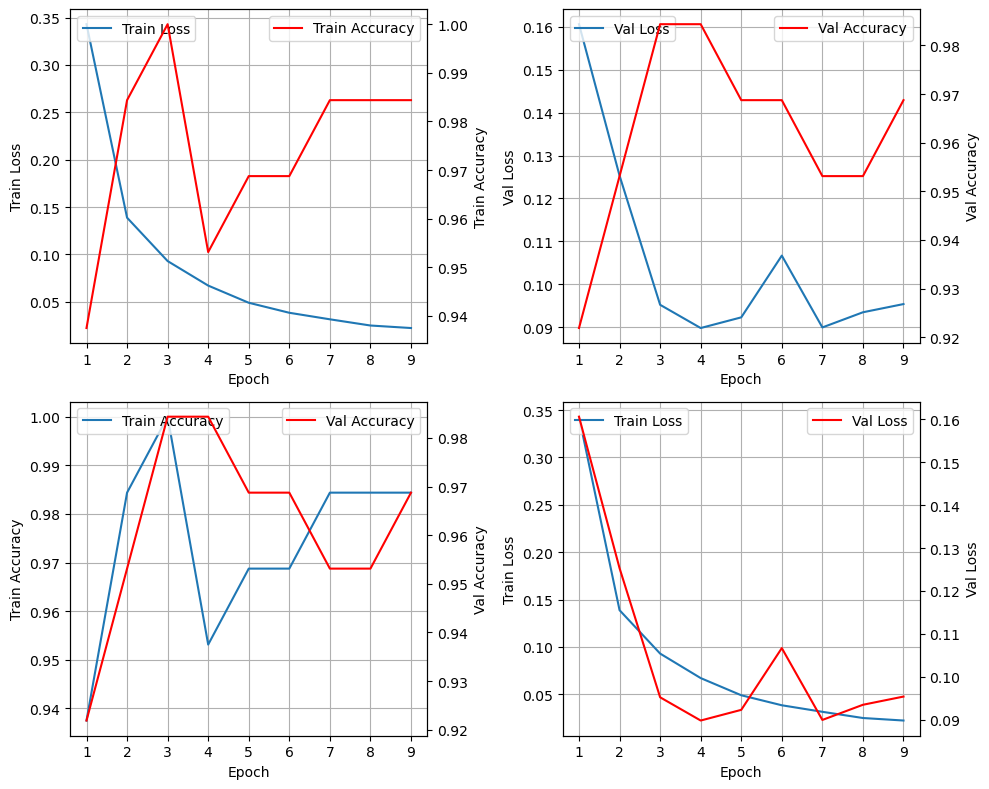

In [31]:
# 손실과 정확도 비교

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(loss_list[0], label="Train Loss")
axes[0, 0].legend(loc="upper left")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Train Loss")
axes[0, 0].set_xticks(np.arange(EPOCHS))
axes[0, 0].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[0, 0].grid()
axes1 = axes[0, 0].twinx()
axes1.plot(accuracy_list[0], label="Train Accuracy", color="red")
axes1.legend(loc="upper right")
axes1.set_ylabel("Train Accuracy")

axes[0, 1].plot(loss_list[1], label="Val Loss")
axes[0, 1].legend(loc="upper left")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Val Loss")
axes[0, 1].set_xticks(np.arange(EPOCHS))
axes[0, 1].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[0, 1].grid()
axes2 = axes[0, 1].twinx()
axes2.plot(accuracy_list[1], label="Val Accuracy", color="red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Val Accuracy")

axes[1, 0].plot(accuracy_list[0], label="Train Accuracy")
axes[1, 0].legend(loc="upper left")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Train Accuracy")
axes[1, 0].set_xticks(np.arange(EPOCHS))
axes[1, 0].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[1, 0].grid()
axes3 = axes[1, 0].twinx()
axes3.plot(accuracy_list[1], label="Val Accuracy", color="red")
axes3.legend(loc="upper right")
axes3.set_ylabel("Val Accuracy")

axes[1, 1].plot(loss_list[0], label="Train Loss")
axes[1, 1].legend(loc="upper left")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Train Loss")
axes[1, 1].set_xticks(np.arange(EPOCHS))
axes[1, 1].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[1, 1].grid()

axes4 = axes[1, 1].twinx()
axes4.plot(loss_list[1], label="Val Loss", color="red")
axes4.legend(loc="upper right")
axes4.set_ylabel("Val Loss")

plt.tight_layout()
plt.show()

In [32]:
# Test Accuracy 직접 계산
pred_target = predict(testDS)
real_target = testDS.target.argmax(dim = 1)
round(((pred_target.argmax(dim = 1) == real_target).sum() / len(testDS)).item(), 2)

0.98

In [ ]:
real_target.shape

torch.Size([10000])